In [1]:
import os,sys,subprocess,glob,cftime,importlib,pickle,itertools
from datetime import datetime
import xarray as xr
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from experiment_configuration.experiment import experiment

def import_from(module, name):
    module = __import__(module, fromlist=[name])
    return getattr(module, name)

%load_ext autoreload
%autoreload 2

In [2]:
ensembles = {}

In [5]:
ens_name = 'ssp370-2025-initial'
ens = dict(
    data = dict(
        obs = xr.open_mfdataset(f'/work/bb1152/u290372/REA_output/heat_wEU_JJA/NCAR/CESM2/{ens_name}/meta/obs/*/*', combine='nested', concat_dim='sim')['obs'].load(),
    ),
    color = 'm',
)
ens['data']['weight'] = ens['data']['obs'].copy() * 0 + 1
ensembles[ens_name] = ens

In [18]:
ens_names = [
    'ssp370-2025-dry-x11',
    'ssp370-2025-wet-x13',
    'ssp370-2025-wet-x14',
    'ssp370-2025-wet-x15',
]

In [19]:
for ens_name in ens_names:
    ens = dict(
        data = dict(
            obs = xr.open_mfdataset(f'/work/bb1152/u290372/REA_output/heat_wEU_JJA/NCAR/CESM2/{ens_name}/meta/obs/*/*', combine='nested', concat_dim='sim')['obs'].load(),
            probability = xr.open_mfdataset(f'/work/bb1152/u290372/REA_output/heat_wEU_JJA/NCAR/CESM2/{ens_name}/meta/probability_season_{ens_name}.nc')['probability'].load(),
            weight = xr.open_mfdataset(f'/work/bb1152/u290372/REA_output/heat_wEU_JJA/NCAR/CESM2/{ens_name}/meta/weight_season_{ens_name}.nc')['weight'].load(),
        ),
        color = 'm',
    )
    ensembles[ens_name] = ens

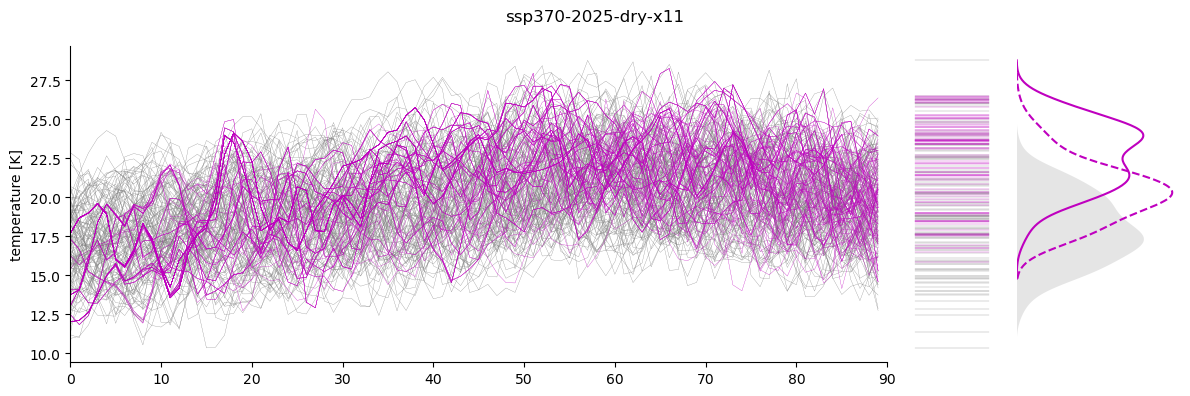

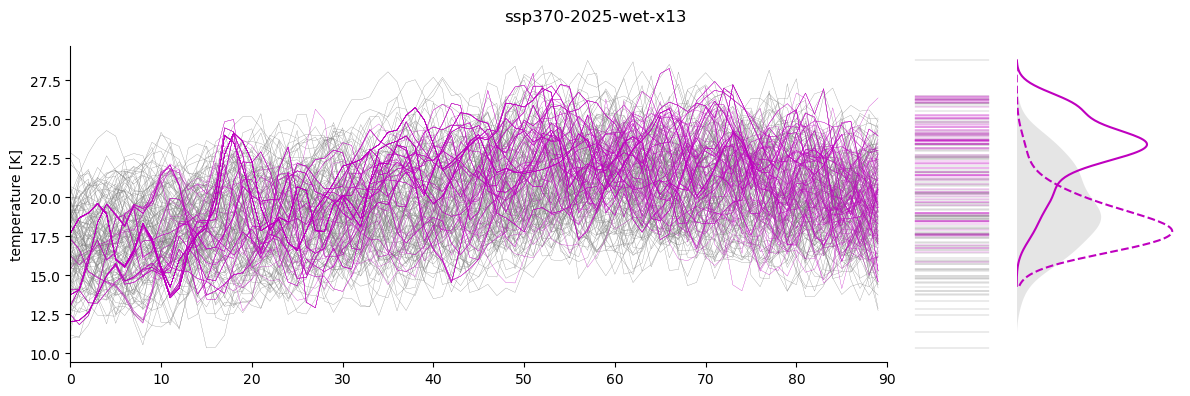

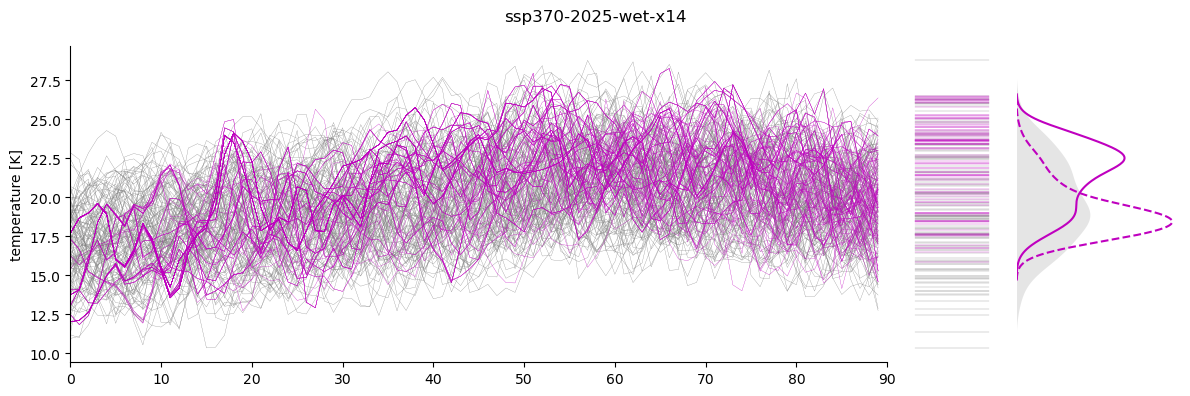

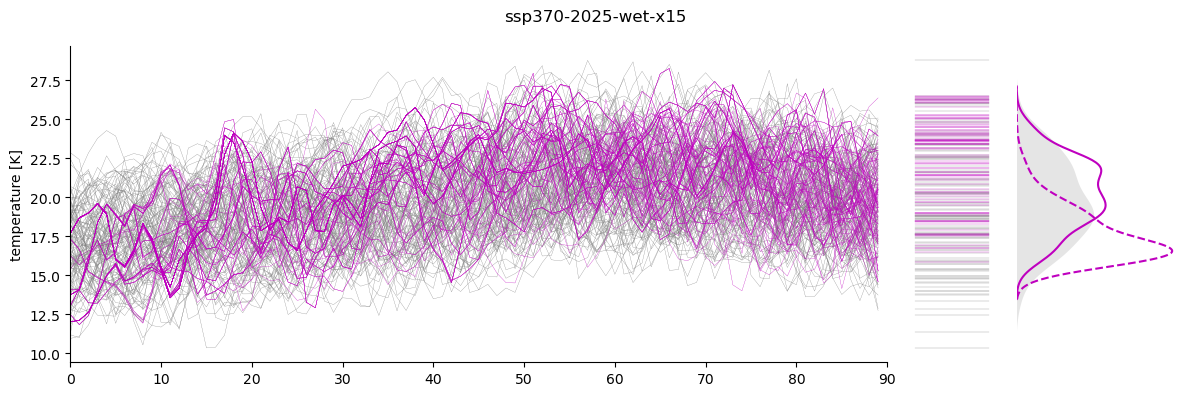

In [20]:
for ens_name in ens_names:
    
    fig,axes = plt.subplots(ncols=3, figsize=(12,4), width_ratios=[10,1,2])

    ens = ensembles['ssp370-2025-initial']
    sns.kdeplot(y=ens['data']['obs'].mean('time'), ax=axes[2], edgecolor='none', color='gray', fill=True, alpha=0.2)
    for sim in ens['data']['obs'].sim.values:
        axes[0].plot(ens['data']['obs'].loc[sim], color='gray', linewidth=0.2)
        axes[1].plot([0,1], [ens['data']['obs'].loc[sim].mean()]*2, color='gray', linewidth=0.22)


    ens = ensembles[ens_name]
    for sim in x.sim.values:
        axes[0].plot(x.loc[sim], color=ens['color'], linewidth=0.2)
        axes[1].plot([0,1], [x.loc[sim].mean()]*2, color=ens['color'], linewidth=0.22)

    sns.kdeplot(y=ens['data']['obs'].mean('time'), weights=ens['data']['weight'], ax=axes[2], color=ens['color'], linestyle='--')
    sns.kdeplot(y=ens['data']['obs'].mean('time'), ax=axes[2], color=ens['color'])

    axes[0].set_xlim(0,90)
    axes[0].spines[['right', 'top']].set_visible(False)
    for ax in axes[1:]:
        ax.spines[['right', 'top', 'bottom','left']].set_visible(False)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
    axes[0].set_ylabel('temperature [K]')
    plt.suptitle(ens_name)
    plt.tight_layout()

### probabilities

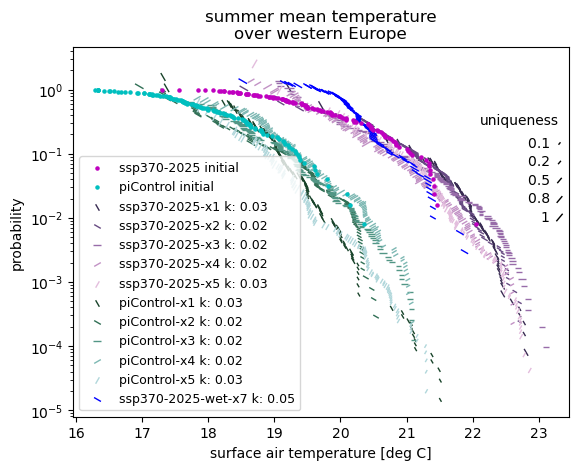

In [3]:
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
fig,ax = plt.subplots()

ax.set_yscale('log')
ax.set_title('summer mean temperature\nover western Europe')
ax.set_xlabel('surface air temperature [deg C]')
ax.set_ylabel('probability')

for climate in climates:
    ens_ini = ensembles[f"{climate}-initial"]
    abso = ens_ini['data']['tas'].mean('time')
    anom = abso - ensembles[f'piControl-initial']['data']['tas'].mean('time')
    x = np.array([(abso >= a).astype(float).mean() for a in abso])
    ax.scatter(abso, x, color=ens_ini['color'], label=ens_ini['label'], marker='.', s=20, zorder=9)
ax.legend(ncols=1, fontsize=9, loc='lower left')
savefig('probabilities_initial')


for ens_name, ens in ensembles.items():
    if 'initial' not in ens_name:
        abso = ens['data']['tas'].mean('time')
        ax.scatter(abso, ens['data']['prob'], color=ens['color'], label=ens['label'], marker=ens['marker'], s=ens['data']['uniq_seas'] * 50)


top_y = 0.82
ax.annotate(f"uniqueness", xy=(0.98,top_y), xycoords='axes fraction', ha='right', va='top')
for y,s in enumerate([0.1,0.2,0.5,0.8,1]):
    ax.scatter([0.98],[top_y-0.08-0.05*y], transform=ax.transAxes, marker=(2,0,320), color='k', s=s*50)
    ax.annotate(f"{s}  ", xy=(0.98,top_y-0.08-0.05*y), xycoords='axes fraction', ha='right', va='center')
ax.legend(ncols=1, fontsize=9, loc='lower left')
savefig('probabilities')

In [10]:
# EOBS
eobs =  xr.open_dataset('tg_ens_mean_0.25deg_reg_v31.0e.nc')['tg'].loc[:, 44:55, -4:12]
eobs = eobs[np.isin(eobs.time.dt.month, [6,7,8])].resample(time='Y').mean()
import regionmask
land = regionmask.defined_regions.natural_earth_v5_0_0.land_110
mask = land.mask(eobs)
mask.values[np.isfinite(mask)] = 1
eobs *= mask
eobs = eobs.weighted(np.cos(np.radians(eobs.latitude))).mean(('latitude','longitude'))

In [11]:
# CESM2 LE
tab = pd.read_csv('JJA_TREFHT_mean.csv')
cesm2_le_current = tab.loc[(tab.year >= 2025-1) & (tab.year <= 2025+1), 'JJA_mean'].values
cesm2_le_current = cesm2_le_current[np.isfinite(cesm2_le_current)]

In [12]:
bias = ensembles[f"piControl-initial"]['data']['tas'].values.mean() - eobs[:30].values.mean()
bias

1.758475491262761

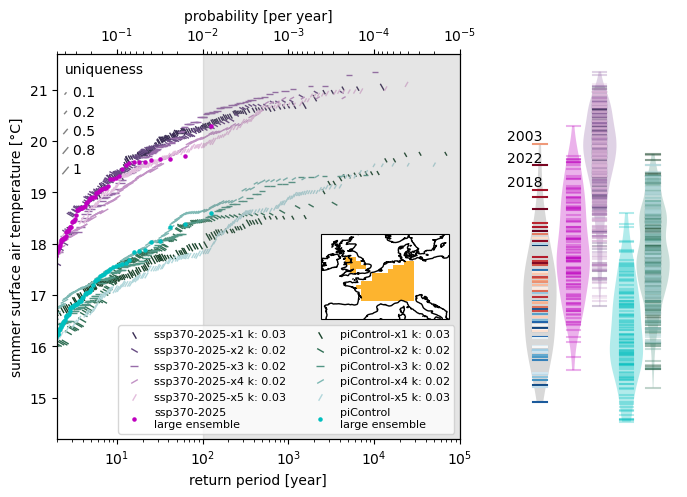

In [13]:
fig,axes = plt.subplots(ncols=2, figsize=(8,5), gridspec_kw=dict(width_ratios=[5,2]), sharey=True)

# Convert the inset axis to a GeoAxes with Cartopy
inset_ax = plt.axes([0.45,0.35,0.17,0.17], projection=cartopy.crs.PlateCarree())

# Add map features
inset_ax.coastlines()

inset_ax.set_extent([-10,20,40,60], crs=cartopy.crs.PlateCarree())
mask = xr.open_dataarray('wEU.nc')
mask.values[mask == 0] = np.nan
mask = mask * 0 + 1
inset_ax.pcolormesh(mask.lon, mask.lat, mask, transform=cartopy.crs.PlateCarree(), vmin=0, vmax=1.2, cmap='plasma')

ax = axes[0]
ax.set_xscale('log')
ax.set_ylabel('summer surface air temperature [°C]')
ax.set_xlabel('return period [year]')
ax.set_xlim(2,10**5)
axP = ax.twiny()
axP.set_xlim(1/2, 1/10**5)
axP.set_xscale('log')
axP.set_xlabel('probability [per year]')
axes[1].axis('off')

# eobs
for yr,y in zip(eobs.time.dt.year.values, eobs.values):
    axes[1].plot([0,1], [y]*2, color=matplotlib.colormaps['RdBu_r']((yr-1950)/(2024-1950)))
    if y > 19:
        axes[1].annotate(f"{yr} ", xy=(1,y), va='bottom', ha='right')
violin_parts = axes[1].violinplot(eobs, positions=[0.5], widths=[2.5])
fix_violin(violin_parts, 'gray')

# CESM2
for i,climate in enumerate(climates):
    pos = i*4 + 5
    l = []
    for ens_name, ens in ensembles.items():
        if 'initial' not in ens_name and climate in ens_name:
            abso = ens['data']['tas'].mean('time') - bias
            ax.scatter(1/ens['data']['prob'], abso, color=ens['color'], label=ens['label'], marker=ens['marker'], s=ens['data']['uniq_seas'] * 50)
            for y in abso:
                axes[1].plot([pos-0.5,pos+0.5], [y]*2, alpha=0.3, color=ens['color'])
            l.append(abso.values.flatten())

    violin_parts = axes[1].violinplot(np.concatenate(l), positions=[pos], widths=[2.5])
    fix_violin(violin_parts, ensembles[f'{climate}-x3']['color'])

    pos -= 2
    ens_ini = ensembles[f"{climate}-initial"]
    #abso = np.concatenate([ens_ini['data']['tas'].mean('time').values - bias, cesm2_le_current - bias])
    abso = ens_ini['data']['tas'].mean('time').values - bias
    x = np.array([(abso >= a).astype(float).mean() for a in abso])
    axes[0].scatter(1/x, abso, label=f'{climate}\nlarge ensemble', marker='.', color=ens_ini['color'], s=20, zorder=9)
    for y in abso:
        axes[1].plot([pos-0.5,pos+0.5], [y]*2, alpha=0.3, color=ens_ini['color'])
    violin_parts = axes[1].violinplot(abso, positions=[pos], widths=[2.5])
    fix_violin(violin_parts, ens_ini['color'])


top_y = 0.98
axes[0].annotate(f"uniqueness", xy=(0.02,top_y), xycoords='axes fraction', ha='left', va='top')
for y,s in enumerate([0.1,0.2,0.5,0.8,1]):
    axes[0].scatter([0.02],[top_y-0.08-0.05*y], transform=ax.transAxes, marker=(2,0,320), color='gray', s=s*50)
    axes[0].annotate(f"{s}  ", xy=(0.04,top_y-0.08-0.05*y), xycoords='axes fraction', ha='left', va='center')

axes[0].legend(ncols=2, fontsize=8, loc='lower right')
axes[0].axvspan(100, 10**5, color='gray', alpha=0.2)
savefig('seasonal_probabailities')

### bootstrapping 

In [24]:
def bootstrap(p, ensemble_ids=range(1,6)):
    l_current = [c for c in itertools.combinations_with_replacement([func(ensembles[f"ssp370-2025-x{i}"], p) for i in ensemble_ids], len(ensemble_ids))]
    l_pic = [c for c in itertools.combinations_with_replacement([func(ensembles[f"piControl-x{i}"], p) for i in ensemble_ids], len(ensemble_ids))]
    combis = [c for c in itertools.product(l_current, l_pic)]
    xx = np.empty([len(combis)])
    for i,c in enumerate(combis):
        s_current, s_pic = c
        weight_current = np.array(s_current)[:,1]
        weight_pic = np.array(s_pic)[:,1]
        xx[i] = np.sum(np.array(s_current)[:,0] * weight_current) / weight_current.sum() - np.sum(np.array(s_pic)[:,0] * weight_pic) / weight_pic.sum()
    return xx

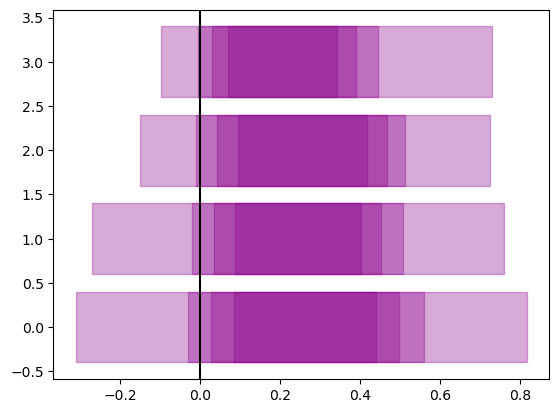

In [27]:
def func(ens, p):
    weight = ens['data']['weight'].copy()
    weight[ens['data']['prob'] > p] = 0
    return float(ens['data']['tas'].mean('time').weighted(weight).mean() - ens['data_initial']['tas'].values.mean()),  float(weight.sum())
    
fig,ax = plt.subplots()
for y,p in enumerate([0.02,0.01,0.002, 0.001]):
    bs = bootstrap(p)
    ax.fill_between(np.nanpercentile(bs, [0,100]), [y-0.4]*2, [y+0.4]*2, color='darkmagenta', alpha=1/3)
    ax.fill_between(np.nanpercentile(bs, [5,95]), [y-0.4]*2, [y+0.4]*2, color='darkmagenta', alpha=1/3)
    ax.fill_between(np.nanpercentile(bs, [10,90]), [y-0.4]*2, [y+0.4]*2, color='darkmagenta', alpha=1/3)
    ax.fill_between(np.nanpercentile(bs, [17,83]), [y-0.4]*2, [y+0.4]*2, color='darkmagenta', alpha=1/3)
ax.axvline(0, color='k')

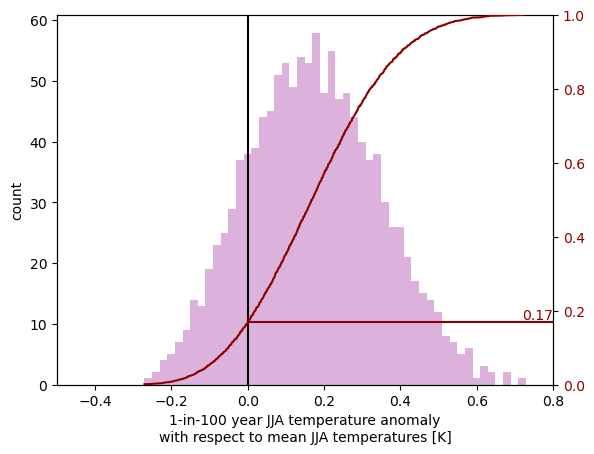

In [40]:
fig,ax = plt.subplots()
_ = ax.hist(xx, bins=np.arange(xx.min(),xx.max()+0.01,0.02), color='darkmagenta', alpha=0.3)
ax.axvline(0, color='k', zorder=10)
ax.set_ylabel('count')
ax.set_xlabel('1-in-100 year JJA temperature anomaly\nwith respect to mean JJA temperatures [K]')

ax2 = ax.twinx()
res = scipy.stats.ecdf(xx)
ax2.plot(res.cdf.quantiles, res.cdf.probabilities, color='darkred', zorder=9)
prc = np.sum(xx < 0) / xx.shape[0]
ax2.plot([0,1], [prc]*2, color='darkred')
ax2.annotate(f"{prc:.2f}", xy=(0.8,prc), ha='right', va='bottom', color='darkred')
ax2.set_ylim(0,1)
ax.set_xlim(-0.5,0.8)
_ = [t.set_color('darkred') for t in ax2.yaxis.get_ticklabels()]

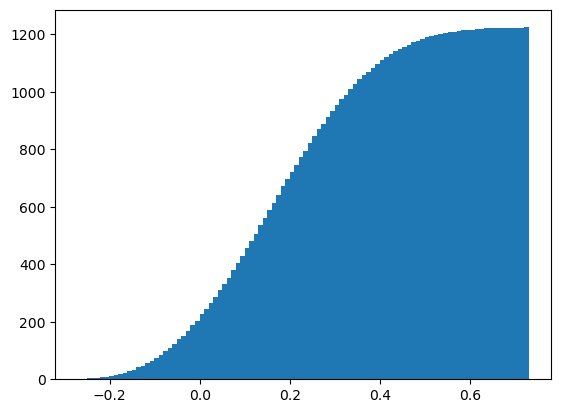

In [39]:
xx = bootstrap(0.01, ensemble_ids=range(2,6))
bins=np.arange(xx.min(),xx.max()+0.01,0.01)
_ = plt.hist(xx, cumulative=True, bins=bins)

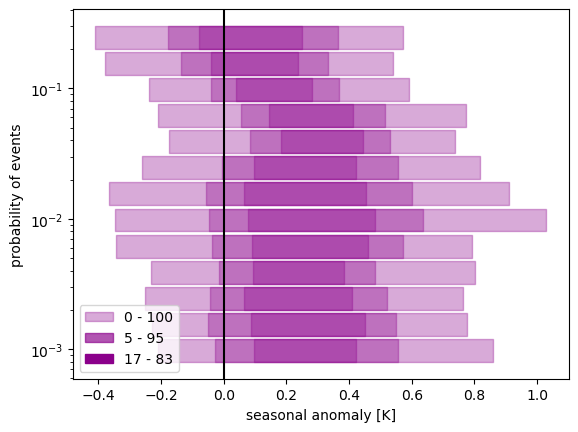

In [107]:
bs_l = []
prob_l = [10**i for i in np.arange(-0.6,-3.2,-0.2)]
for p in prob_l:
    p_low = p*0.8
    p_high = p*1.2
    xx = bootstrap(p_low, p_high)
    bs_l.append(xx)
    
fig,ax = plt.subplots()
for p,bs in zip(prob_l, bs_l):
    p_low = p*0.8
    p_high = p*1.2
    ax.fill_between(np.nanpercentile(bs, [0,100]), [p_low]*2, [p_high]*2, color='darkmagenta', alpha=1/3)
    ax.fill_between(np.nanpercentile(bs, [5,95]), [p_low]*2, [p_high]*2, color='darkmagenta', alpha=1/3)
    ax.fill_between(np.nanpercentile(bs, [17,83]), [p_low]*2, [p_high]*2, color='darkmagenta', alpha=1/3)

alpha=0
for p in [0,5,17]:
    alpha += 1/3
    ax.fill_between([],[],[], color='darkmagenta', alpha=alpha, label=f"{p} - {100-p}")
ax.set_yscale('log')
ax.axvline(0, color='k')
ax.set_xlabel('seasonal anomaly [K]')
ax.set_ylabel('probability of events')
ax.legend(loc='lower left')

In [ ]:
def bootstrap(p_low, p_high, ensemble_ids=range(1,6)):
    def func(ens):
        selection = ((ens['data']['prob'] > p_low) & (ens['data']['prob'] < p_high))
        weight = get_weight_for_selection(selection.sim.where(selection, drop=True).values, ens['exp'])
        return float((ens['data']['tas'].mean('time') - ens['data_initial']['tas'].values.mean())[selection].weighted(weight).mean()),  float(weight.sum())
        
    l_current = [c for c in itertools.combinations_with_replacement([func(ensembles[f"ssp370-2025-x{i}"]) for i in ensemble_ids], 5)]
    l_pic = [c for c in itertools.combinations_with_replacement([func(ensembles[f"piControl-x{i}"]) for i in ensemble_ids], 5)]
    combis = [c for c in itertools.product(l_current, l_pic)]
    xx = np.empty([len(combis)])
    for i,c in enumerate(combis):
        s_current, s_pic = c
        weight_current = np.array(s_current)[:,1]
        weight_pic = np.array(s_pic)[:,1]
        xx[i] = np.sum(np.array(s_current)[:,0] * weight_current) / weight_current.sum() - np.sum(np.array(s_pic)[:,0] * weight_pic) / weight_pic.sum()
    return xx

In [19]:
p = 0.01
p_low = p*0.8
p_high = p*1.2
xx = bootstrap(p_low, p_high)

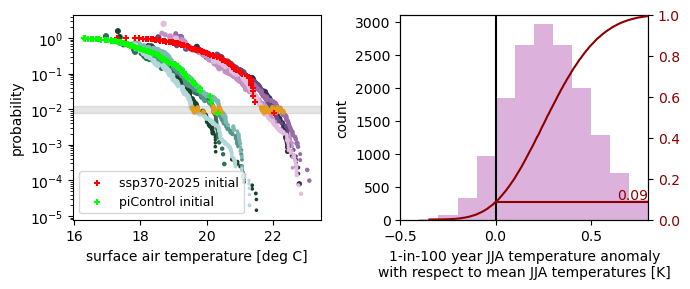

In [14]:
fig,axes = plt.subplots(ncols=2, figsize=(7,3))
ax = axes[0]
ax.set_yscale('log')
ax.set_xlabel('surface air temperature [deg C]')
ax.set_ylabel('probability')

for climate in climates:
    ens_ini = ensembles[f"{climate}-initial"]
    abso = ens_ini['data']['tas'].mean('time')
    anom = abso - ensembles[f'piControl-initial']['data']['tas'].mean('time')
    x = np.array([(abso >= a).astype(float).mean() for a in abso])
    ax.scatter(abso, x, color=ens_ini['color'], label=ens_ini['label'], marker='+', s=20, zorder=9)
ax.legend(ncols=1, fontsize=9, loc='lower left')
savefig('probabilities_initial')

for ens_name, ens in ensembles.items():
    if 'initial' not in ens_name:
        abso = ens['data']['tas'].mean('time')
        x = np.array([np.sum((abso >= a).astype(float) * ens['data']['prob']) for a in abso])    
        ax.scatter(abso, ens['data']['prob'], color=ens['color'], label=ens['label'], marker='.', s=ens['data']['uniq_seas'] * 50)

for r,climate in enumerate(climates):
    weight = xr.concat([ensembles[f"{climate}-x{i}"]['data']['uniq_seas'] for i in range(1,6)], dim='sim').sortby('sim')
    obs = xr.concat([ensembles[f"{climate}-x{i}"]['data']['tas'].mean('time') for i in range(1,6)], dim='sim').sortby('sim')
    prob = xr.concat([ensembles[f"{climate}-x{i}"]['data']['prob'] for i in range(1,6)], dim='sim').sortby('sim')

    selection = ((prob > p_low) & (prob < p_high))
    ax.scatter(obs[selection], prob[selection], color='orange', marker='.', s=20)

ax.axhspan(p_low, p_high, color='gray', alpha=0.2)

ax = axes[1]
_ = ax.hist(xx, bins=np.arange(-0.5,0.9,0.1), color='darkmagenta', alpha=0.3)
ax.axvline(0, color='k', zorder=10)
ax.set_ylabel('count')
ax.set_xlabel('1-in-100 year JJA temperature anomaly\nwith respect to mean JJA temperatures [K]')

ax2 = ax.twinx()
res = scipy.stats.ecdf(xx)
ax2.plot(res.cdf.quantiles, res.cdf.probabilities, color='darkred', zorder=9)
prc = np.sum(xx < 0) / xx.shape[0]
ax2.plot([0,1], [prc]*2, color='darkred')
ax2.annotate(f"{prc:.2f}", xy=(0.8,prc), ha='right', va='bottom', color='darkred')
ax2.set_ylim(0,1)
ax.set_xlim(-0.5,0.8)
_ = [t.set_color('darkred') for t in ax2.yaxis.get_ticklabels()]
plt.tight_layout()

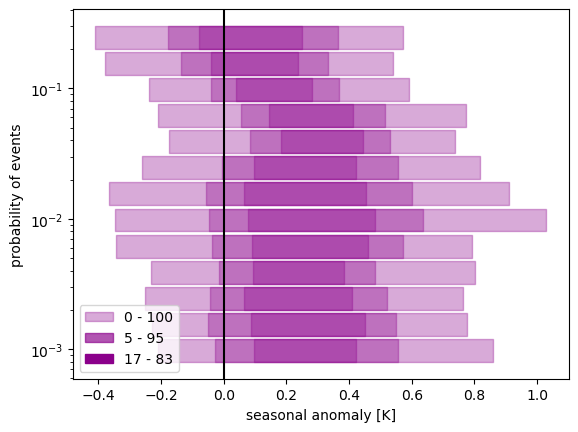

In [ ]:
bs_l = []
prob_l = [10**i for i in np.arange(-0.6,-3.2,-0.2)]
for p in prob_l:
    p_low = p*0.8
    p_high = p*1.2
    xx = bootstrap(p_low, p_high)
    bs_l.append(xx)
    
fig,ax = plt.subplots()
for p,bs in zip(prob_l, bs_l):
    p_low = p*0.8
    p_high = p*1.2
    ax.fill_between(np.nanpercentile(bs, [0,100]), [p_low]*2, [p_high]*2, color='darkmagenta', alpha=1/3)
    ax.fill_between(np.nanpercentile(bs, [5,95]), [p_low]*2, [p_high]*2, color='darkmagenta', alpha=1/3)
    ax.fill_between(np.nanpercentile(bs, [17,83]), [p_low]*2, [p_high]*2, color='darkmagenta', alpha=1/3)

alpha=0
for p in [0,5,17]:
    alpha += 1/3
    ax.fill_between([],[],[], color='darkmagenta', alpha=alpha, label=f"{p} - {100-p}")
ax.set_yscale('log')
ax.axvline(0, color='k')
ax.set_xlabel('seasonal anomaly [K]')
ax.set_ylabel('probability of events')
ax.legend(loc='lower left')

#### same but only with 3,4,5

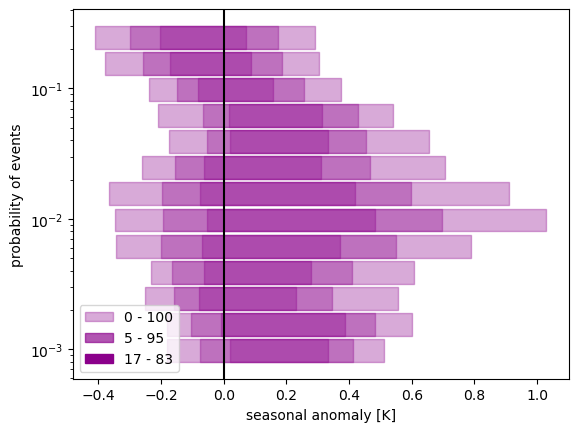

In [20]:
bs_l = []
prob_l = [10**i for i in np.arange(-0.6,-3.2,-0.2)]
for p in prob_l:
    p_low = p*0.8
    p_high = p*1.2
    xx = bootstrap(p_low, p_high, ensemble_ids=[3,4,5])
    bs_l.append(xx)
    
fig,ax = plt.subplots()
for p,bs in zip(prob_l, bs_l):
    p_low = p*0.8
    p_high = p*1.2
    ax.fill_between(np.nanpercentile(bs, [0,100]), [p_low]*2, [p_high]*2, color='darkmagenta', alpha=1/3)
    ax.fill_between(np.nanpercentile(bs, [5,95]), [p_low]*2, [p_high]*2, color='darkmagenta', alpha=1/3)
    ax.fill_between(np.nanpercentile(bs, [17,83]), [p_low]*2, [p_high]*2, color='darkmagenta', alpha=1/3)

alpha=0
for p in [0,5,17]:
    alpha += 1/3
    ax.fill_between([],[],[], color='darkmagenta', alpha=alpha, label=f"{p} - {100-p}")
ax.set_yscale('log')
ax.axvline(0, color='k')
ax.set_xlabel('seasonal anomaly [K]')
ax.set_ylabel('probability of events')
ax.legend(loc='lower left')

### daily distribution

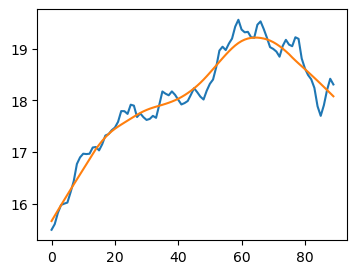

In [9]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
seas_cycle = ensembles[f'piControl-initial']['data']['tas'].mean('sim')
seas_cycle_smooth = lowess(seas_cycle.values, np.arange(1,91,1), frac=1./3)[:,1]
fig,ax = plt.subplots(figsize=(4,3))
ax.plot(seas_cycle)
ax.plot(seas_cycle_smooth)

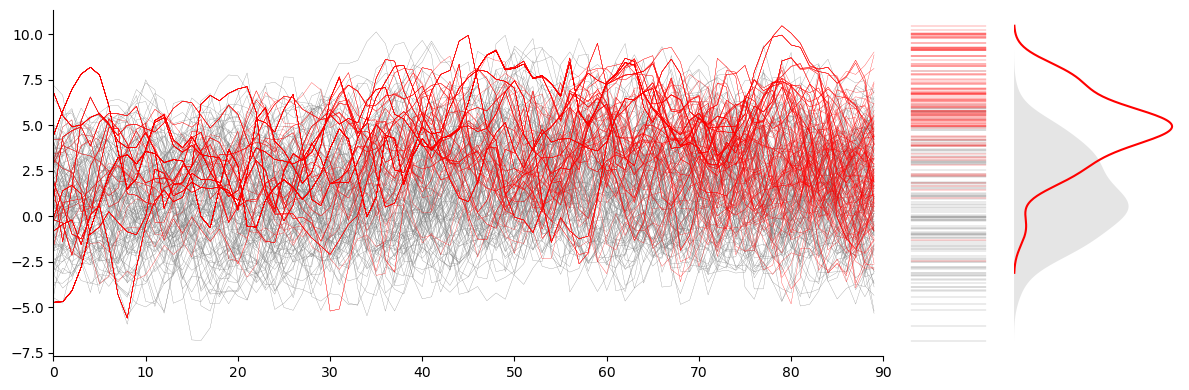

In [10]:
ens = ensembles['ssp370-2025-x5']
#ens = ensembles['piControl-x5']

fig,axes = plt.subplots(ncols=3, figsize=(12,4), width_ratios=[10,1,2])
x = ens['data_initial']['tas'] - seas_cycle_smooth
sns.kdeplot(y=x.mean('time'), ax=axes[2], edgecolor='none', color='gray', fill=True, alpha=0.2)
for sim in x.sim.values:
    axes[0].plot(x.loc[sim], color='gray', linewidth=0.2)
    axes[1].plot([0,1], [x.loc[sim].mean()]*2, color='gray', linewidth=0.22)

x = ens['data']['tas'] - seas_cycle_smooth
for sim in x.sim.values:
    axes[0].plot(x.loc[sim], color='red', linewidth=0.2)
    axes[1].plot([0,1], [x.loc[sim].mean()]*2, color='red', linewidth=0.22)
df = pd.DataFrame()
df['x'] = x.mean('time').values
df['w'] = ens['data']['uniq_seas'].values
df['w'] /= df['w'] .sum()
sns.kdeplot(df, y='x', weights='w', ax=axes[2], color='red')

axes[0].set_xlim(0,90)
axes[0].spines[['right', 'top']].set_visible(False)
for ax in axes[1:]:
    ax.spines[['right', 'top', 'bottom','left']].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
plt.tight_layout()

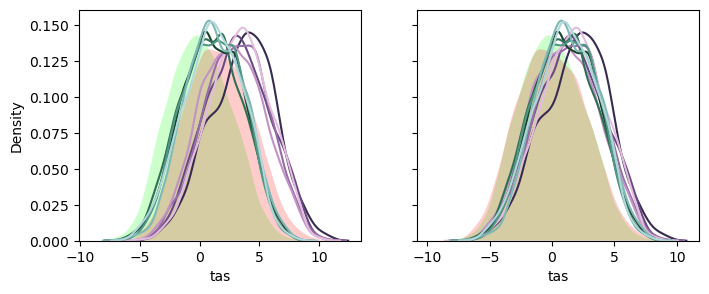

In [19]:
fig,axes = plt.subplots(ncols=2, figsize=(8,3), sharey=True)
ax.spines[['right', 'top']].set_visible(False)
for ens_name, ens in ensembles.items():

    if 'initial' in ens_name:
        xx = (ens['data']['tas'] - seas_cycle_smooth).values.flatten()
        sns.kdeplot(xx, ax=axes[0], edgecolor='none', color=ens['color'], fill=True, alpha=0.2)
        xx -= xx.mean()
        sns.kdeplot(xx, ax=axes[1], edgecolor='none', color=ens['color'], fill=True, alpha=0.2)
    
    else:
        xx = (ens['data']['tas'] - seas_cycle_smooth).values.flatten()
        df = pd.DataFrame()
        df['tas'] = xx
        df['w'] = ens['data']['uniq_day'].values.flatten()
        df['w'] /= df['w'].sum()
        sns.kdeplot(df, x='tas', weights='w', ax=axes[0], color=ens['color'])

        xx -= (ens['data_initial']['tas'] - seas_cycle_smooth).values.flatten().mean()
        df['tas'] = xx
        sns.kdeplot(df, x='tas', weights='w', ax=axes[1], color=ens['color'])

#### change in variance

In [143]:
for ens_name, ens in ensembles.items():
    values = (ens['data']['tas'] - seas_cycle_smooth).values.flatten()
    if 'initial' in ens_name:
        average = values.mean()
        std = values.std()
    else:
        average = np.average(values, weights=ens['data']['uniq_day'].values.flatten())
        std = np.average((values-average)**2, weights=ens['data']['uniq_day'].values.flatten()) **0.5
        
    print(ens_name, average.round(1), std.round(2))


piControl-initial 0.0 2.6
ssp370-2025-initial 1.7 2.71
ssp370-2025-x1 3.6 2.69
ssp370-2025-x2 3.1 2.72
ssp370-2025-x3 3.0 2.66
ssp370-2025-x4 2.7 2.69
ssp370-2025-x5 3.3 2.6
piControl-x1 1.1 2.53
piControl-x2 1.0 2.57
piControl-x3 1.1 2.48
piControl-x4 1.3 2.47
piControl-x5 1.2 2.52


In [159]:
def bootstrap(p_low, p_high):
    def func(ens):
        selection = ((ens['data']['prob'] > p_low) & (ens['data']['prob'] < p_high))
        values = (ens['data']['tas'][selection] - seas_cycle_smooth).values.flatten()
        average = np.average(values, weights=ens['data']['uniq_day'][selection].values.flatten())
        std = np.average((values-average)**2, weights=ens['data']['uniq_day'][selection].values.flatten()) **0.5
        return float(std),  float(ens['data']['uniq_seas'][selection].sum())
        
    l_current = [c for c in itertools.combinations_with_replacement([func(ensembles[f"ssp370-2025-x{i}"]) for i in range(1,6)], 5)]
    l_pic = [c for c in itertools.combinations_with_replacement([func(ensembles[f"piControl-x{i}"]) for i in range(1,6)], 5)]
    combis = [c for c in itertools.product(l_current, l_pic)]
    xx = np.empty([len(combis)])
    for i,c in enumerate(combis):
        s_current, s_pic = c
        weight_current = np.array(s_current)[:,1]
        weight_pic = np.array(s_pic)[:,1]
        xx[i] = np.sum(np.array(s_current)[:,0] * weight_current) / weight_current.sum() - np.sum(np.array(s_pic)[:,0] * weight_pic) / weight_pic.sum()
    return xx

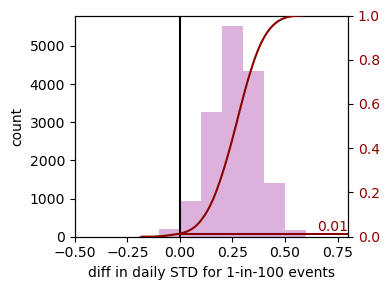

In [162]:
p = 0.01
p_low = p*0.8
p_high = p*1.2
xx = bootstrap(p_low, p_high)

fig,ax = plt.subplots(figsize=(4,3))
_ = ax.hist(xx, bins=np.arange(-0.5,0.9,0.1), color='darkmagenta', alpha=0.3)
ax.axvline(0, color='k', zorder=10)
ax.set_ylabel('count')
ax.set_xlabel('diff in daily STD for 1-in-100 events')

ax2 = ax.twinx()
res = scipy.stats.ecdf(xx)
ax2.plot(res.cdf.quantiles, res.cdf.probabilities, color='darkred', zorder=9)
prc = np.sum(xx < 0) / xx.shape[0]
ax2.plot([0,1], [prc]*2, color='darkred')
ax2.annotate(f"{prc:.2f}", xy=(0.8,prc), ha='right', va='bottom', color='darkred')
ax2.set_ylim(0,1)
ax.set_xlim(-0.5,0.8)
_ = [t.set_color('darkred') for t in ax2.yaxis.get_ticklabels()]
plt.tight_layout()


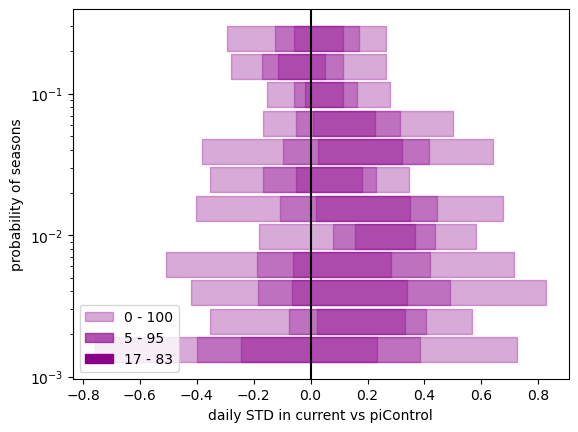

In [167]:
bs_l = []
prob_l = [10**i for i in np.arange(-0.6,-3,-0.2)]
for p in prob_l:
    p_low = p*0.8
    p_high = p*1.2
    xx = bootstrap(p_low, p_high)
    bs_l.append(xx)
    
fig,ax = plt.subplots()
for p,bs in zip(prob_l, bs_l):
    p_low = p*0.8
    p_high = p*1.2
    ax.fill_between(np.nanpercentile(bs, [0,100]), [p_low]*2, [p_high]*2, color='darkmagenta', alpha=1/3)
    ax.fill_between(np.nanpercentile(bs, [5,95]), [p_low]*2, [p_high]*2, color='darkmagenta', alpha=1/3)
    ax.fill_between(np.nanpercentile(bs, [17,83]), [p_low]*2, [p_high]*2, color='darkmagenta', alpha=1/3)

alpha=0
for p in [0,5,17]:
    alpha += 1/3
    ax.fill_between([],[],[], color='darkmagenta', alpha=alpha, label=f"{p} - {100-p}")
ax.set_yscale('log')
ax.axvline(0, color='k')
ax.set_xlabel('daily STD in current vs piControl')
ax.set_ylabel('probability of seasons')
ax.legend(loc='lower left')

### hot days

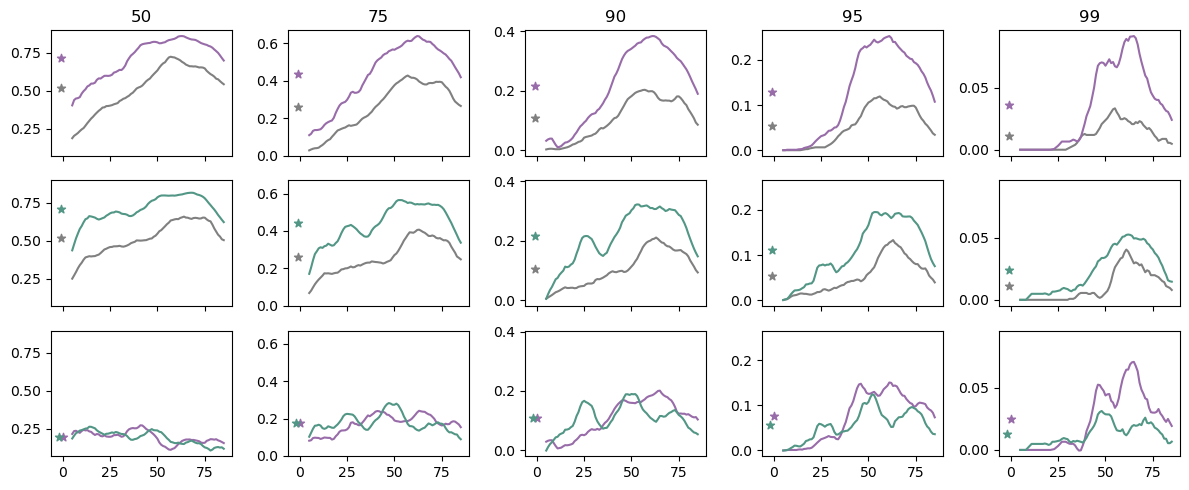

In [96]:
fig,axes = plt.subplots(ncols=5, nrows=3, figsize=(12,5), sharex=True, sharey='col')
for r,climate in enumerate(climates):
    weight = xr.concat([ensembles[f"{climate}-x{i}"]['data']['uniq_seas'] for i in range(1,6)], dim='sim').sortby('sim')
    tas = xr.concat([ensembles[f"{climate}-x{i}"]['data']['tas'] for i in range(1,6)], dim='sim').sortby('sim')
    prob = xr.concat([ensembles[f"{climate}-x{i}"]['data']['prob'] for i in range(1,6)], dim='sim').sortby('sim')

    for c,p in enumerate([50, 75, 90, 95, 99]):
        axes[0,c].set_title(p)
        thresh = np.percentile(ensembles[f"{climate}-initial"]['data']['tas'], p)
        yi = (ensembles[f"{climate}-initial"]['data']['tas'] > thresh).sum('sim') / 126
        yg = (tas > thresh).weighted(weight).sum('sim') / weight.sum('sim')
        yi = yi.rolling(time=10, center=True).mean()
        yg = yg.rolling(time=10, center=True).mean()
        axes[r,c].plot(yi, color='gray')
        axes[r,c].scatter(-1, yi.mean(), color='gray', marker='*')
        axes[r,c].plot(yg, color=ensembles[f"{climate}-x3"]['color'])
        axes[r,c].scatter(-1, yg.mean(), color=ensembles[f"{climate}-x3"]['color'], marker='*')
        axes[2,c].plot(yg - yi, color=ensembles[f"{climate}-x3"]['color'])
        axes[2,c].scatter(-r*2, yg.mean() - yi.mean(), color=ensembles[f"{climate}-x3"]['color'], marker='*')
    plt.tight_layout()

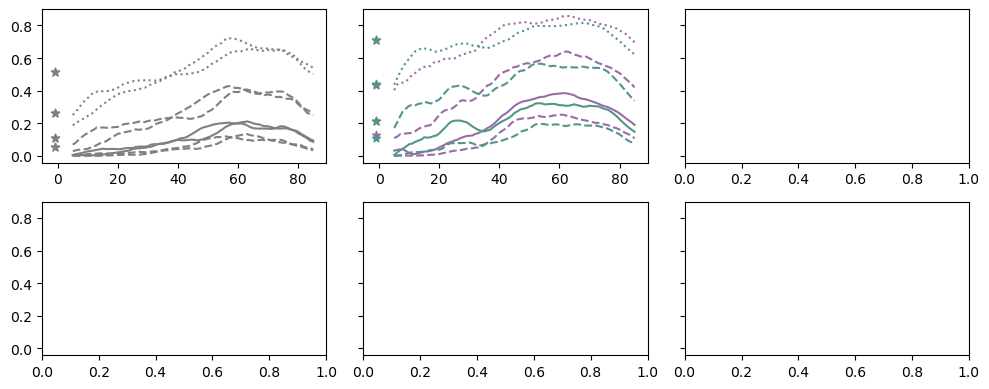

In [104]:
fig,axes = plt.subplots(ncols=3, nrows=2, figsize=(10,4), sharey=True)
for r,climate in enumerate(climates):
    weight = xr.concat([ensembles[f"{climate}-x{i}"]['data']['uniq_seas'] for i in range(1,6)], dim='sim').sortby('sim')
    tas = xr.concat([ensembles[f"{climate}-x{i}"]['data']['tas'] for i in range(1,6)], dim='sim').sortby('sim')
    prob = xr.concat([ensembles[f"{climate}-x{i}"]['data']['prob'] for i in range(1,6)], dim='sim').sortby('sim')

    for p, linestyle in zip([50, 75, 90, 95], [':','--','-','--']):
        thresh = np.percentile(ensembles[f"{climate}-initial"]['data']['tas'], p)
        yi = (ensembles[f"{climate}-initial"]['data']['tas'] > thresh).sum('sim') / 126
        yg = (tas > thresh).weighted(weight).sum('sim') / weight.sum('sim')
        yi = yi.rolling(time=10, center=True).mean()
        yg = yg.rolling(time=10, center=True).mean()
        axes[0,0].plot(yi, color='gray', linestyle=linestyle)
        axes[0,0].scatter(-1, yi.mean(), color='gray', marker='*')
        axes[0,1].plot(yg, color=ensembles[f"{climate}-x3"]['color'], linestyle=linestyle)
        axes[0,1].scatter(-1, yg.mean(), color=ensembles[f"{climate}-x3"]['color'], marker='*')
    plt.tight_layout()

## quantile transitions

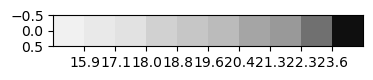

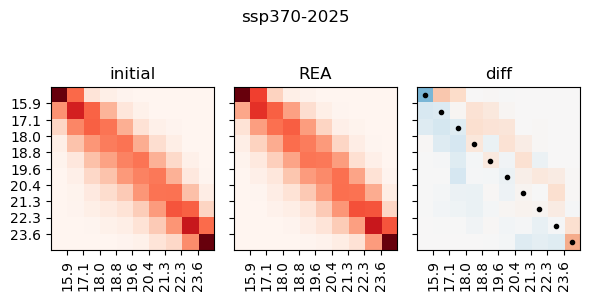

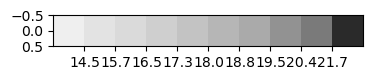

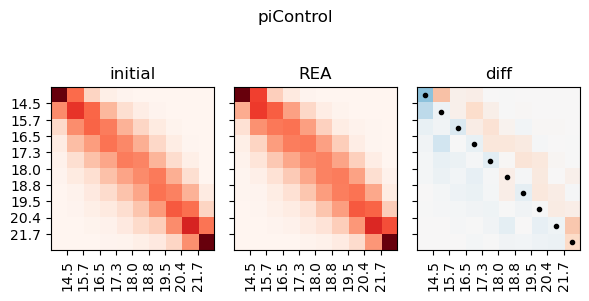

In [59]:
for climate in climates:
    weight = xr.concat([ensembles[f"{climate}-x{i}"]['data']['uniq_day'] for i in range(1,6)], dim='sim').sortby('sim')
    tas = xr.concat([ensembles[f"{climate}-x{i}"]['data']['tas'] for i in range(1,6)], dim='sim').sortby('sim')
    prob = xr.concat([ensembles[f"{climate}-x{i}"]['data']['prob'] for i in range(1,6)], dim='sim').sortby('sim')

    bins = np.percentile(ensembles[f"{climate}-initial"]['data']['tas'], np.arange(10,100,10))

    binned_ini = np.digitize(ensembles[f"{climate}-initial"]['data']['tas'], bins)
    binned_gklt = np.digitize(tas, bins)

    freq_gklt = np.array([[np.sum(weight * np.array(binned_gklt == i, 'float')) / weight.sum() for i in np.unique(binned_gklt)]])
    fig,ax = plt.subplots(figsize=(4,1))
    ax.imshow(freq_gklt, vmin=0, vmax=0.25, cmap='Greys')
    ax.set_xticks(np.unique(binned_ini)[1:]-0.5)
    ax.set_xticklabels(bins.round(1))


    tm_ini = np.zeros([len(bins)+1, len(bins)+1])
    for i in np.unique(binned_ini):
        for j in np.unique(binned_ini):
            tm_ini[i,j] = np.sum((binned_ini[:,:-1] == i) & (binned_ini[:,1:] == j)) / np.sum(binned_ini[:,:-1] == i)

    tm_gklt = np.zeros([len(bins)+1, len(bins)+1])
    for i in np.unique(binned_gklt):
        for j in np.unique(binned_gklt):
            tm_gklt[i,j] = np.sum(weight[:,:-1] * np.array((binned_gklt[:,:-1] == i) & (binned_gklt[:,1:] == j), 'float')) / np.sum(weight[:,:-1] * np.array(binned_gklt[:,:-1] == i, 'float'))

    fig,axes = plt.subplots(ncols=3, figsize=(6,3), sharey=True)
    plt.suptitle(climate)
    axes[0].imshow(tm_ini, vmin=0, vmax=0.5, cmap='Reds')
    axes[1].imshow(tm_gklt, vmin=0, vmax=0.5, cmap='Reds')
    axes[2].imshow((tm_gklt - tm_ini), vmin=-0.2, vmax=0.2, cmap='RdBu_r')
    axes[2].scatter(np.unique(binned_ini),np.unique(binned_ini), color='k')
    axes[0].set_yticks(np.unique(binned_ini)[1:]-0.5)
    axes[0].set_yticklabels(bins.round(1))
    for ax in axes:
        ax.set_xticks(np.unique(binned_ini)[1:]-0.5)
        ax.set_xticklabels(bins.round(1), rotation=90)
    axes[0].set_title('initial')
    axes[1].set_title('REA')
    axes[2].set_title('diff')
    plt.tight_layout()


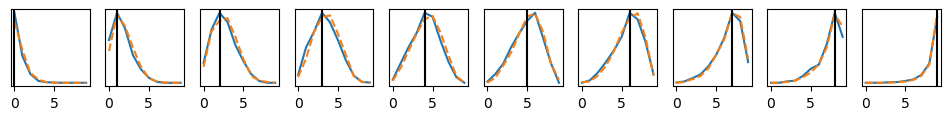

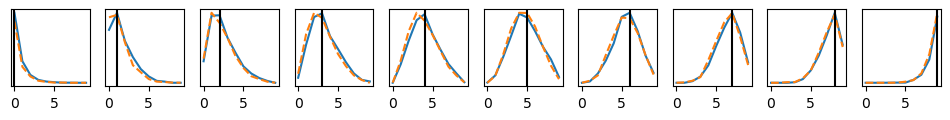

In [60]:
fig,axes=plt.subplots(ncols=len(bins)+1, figsize=(12,1))
for i in np.unique(binned_ini):
    axes[i].plot(tm_ini[i], linestyle='-')
    axes[i].plot(tm_gklt[i], linestyle='--')
    axes[i].axvline(i, color='k')
    axes[i].set_yticks([])

fig,axes=plt.subplots(ncols=len(bins)+1, figsize=(12,1))
for i in np.unique(binned_ini):
    axes[i].plot(tm_ini[:,i], linestyle='-')
    axes[i].plot(tm_gklt[:,i], linestyle='--')
    axes[i].axvline(i, color='k')
    axes[i].set_yticks([])

### heat wave timings

In [94]:
# https://stackoverflow.com/questions/1066758/find-length-of-sequences-of-identical-values-in-a-numpy-array-run-length-encodi
def rle(inarray):
        """ run length encoding. Partial credit to R rle function. 
            Multi datatype arrays catered for including non Numpy
            returns: tuple (runlengths, startpositions, values) """
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]               # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)   # must include last element posi
            z = np.diff(np.append(-1, i))       # run lengths
            p = np.cumsum(np.append(0, z))[:-1] # positions
            return(z, p, ia[i])

def hw_stats(ens_data, thresh):
    hot = (ens_data > thresh).astype(int)
    hw_len = np.array([], 'int')
    hw_start = np.array([], 'int')
    for sim in hot.sim.values:
        l,start,v = rle(hot.loc[sim].values)
        hw_len = np.append(hw_len, l[v == 1])
        hw_start = np.append(hw_start, start[v == 1])
    return hw_len,hw_start

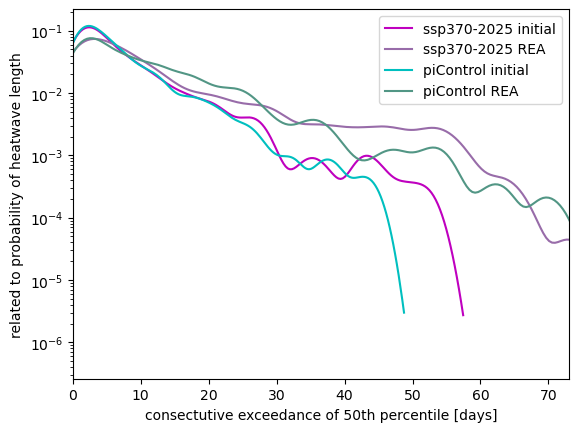

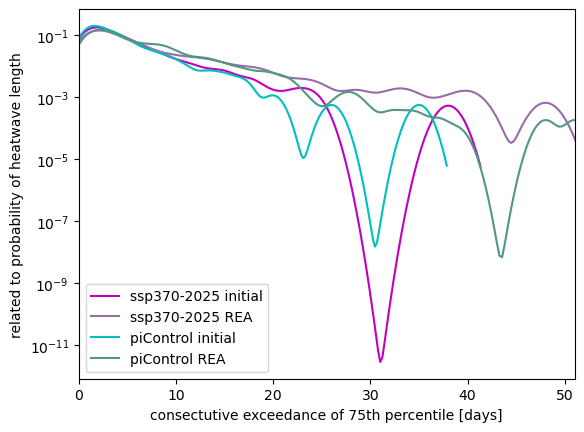

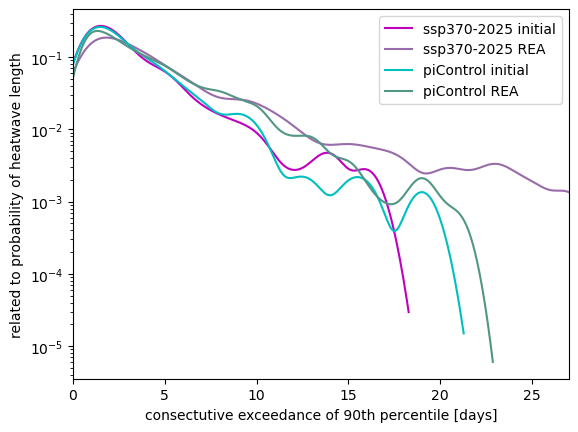

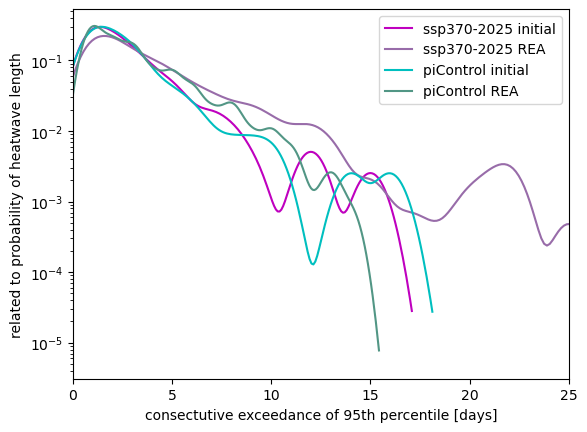

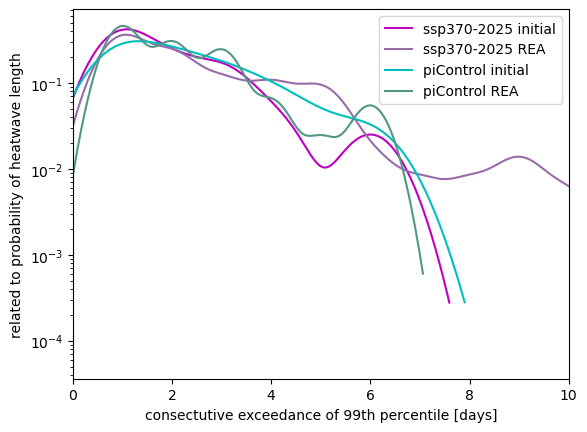

In [95]:
for perc in [50,75,90,95,99]:
    fig,ax = plt.subplots()
    mx = 0
    for r,climate in enumerate(climates):
        weight = xr.concat([ensembles[f"{climate}-x{i}"]['data']['uniq_seas'] for i in range(1,6)], dim='sim').sortby('sim')
        tas = xr.concat([ensembles[f"{climate}-x{i}"]['data']['tas'] for i in range(1,6)], dim='sim').sortby('sim')
        prob = xr.concat([ensembles[f"{climate}-x{i}"]['data']['prob'] for i in range(1,6)], dim='sim').sortby('sim')

        thresh = np.percentile(ensembles[f"{climate}-initial"]['data']['tas'], perc)
        hw_len,hw_start = hw_stats(ensembles[f"{climate}-initial"]['data']['tas'], thresh)
        sns.kdeplot(hw_len, label=f"{climate} initial", color=ensembles[f"{climate}-initial"]['color'])
        mx = max([mx, max(hw_len)])

        hw_len,hw_start = hw_stats(tas, thresh)
        sns.kdeplot(hw_len, label=f"{climate} REA", color=ensembles[f"{climate}-x3"]['color'])
        mx = max([mx, max(hw_len)])

    ax.legend()
    ax.set_xlim(0,mx)
    ax.set_yscale('log')
    ax.set_ylabel('related to probability of heatwave length')
    ax.set_xlabel(f'consectutive exceedance of {perc}th percentile [days]')

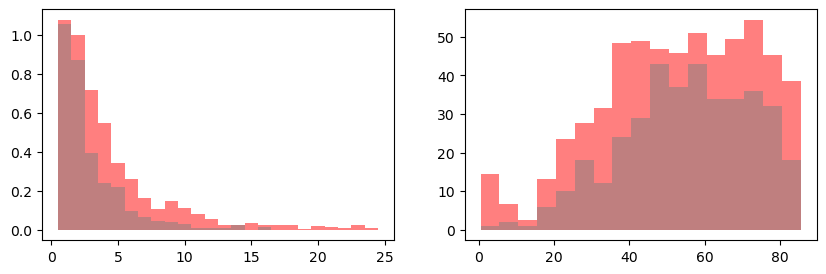

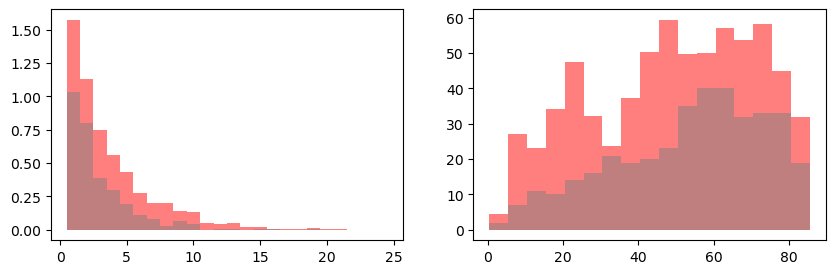

In [62]:
for r,climate in enumerate(climates):
    weight = xr.concat([ensembles[f"{climate}-x{i}"]['data']['uniq_seas'] for i in range(1,6)], dim='sim').sortby('sim')
    obs = xr.concat([ensembles[f"{climate}-x{i}"]['data']['tas'] for i in range(1,6)], dim='sim').sortby('sim')
    prob = xr.concat([ensembles[f"{climate}-x{i}"]['data']['prob'] for i in range(1,6)], dim='sim').sortby('sim')

    fig,axes = plt.subplots(ncols=2, figsize=(10,3))
    bins_len = np.arange(0.5,25.5,1)
    bins_start = np.arange(0.5,90.5,5)
    thresh = np.percentile(ensembles[f"{climate}-initial"]['data']['tas'], 90)
    
    hw_len,hw_start = hw_stats(obs, thresh)
    count,_ = np.histogram(hw_len, bins=bins_len)
    count = count / 5 / 126
    for xl,xh,c in zip(bins_len[:-1],bins_len[1:],count):
        axes[0].fill_between([xl,xh],[c]*2, color='r', alpha=0.5, edgecolor='none')  

    count,_ = np.histogram(hw_start, bins=bins_start)
    count = count / 5
    for xl,xh,c in zip(bins_start[:-1],bins_start[1:],count):
        axes[1].fill_between([xl,xh],[c]*2, color='r', alpha=0.5, edgecolor='none')  

    hw_len,hw_start = hw_stats(ensembles[f"{climate}-initial"]['data']['tas'], thresh)
    count,_ = np.histogram(hw_len, bins=bins_len)
    count = count / 126
    for xl,xh,c in zip(bins_len[:-1],bins_len[1:],count):
        axes[0].fill_between([xl,xh],[c]*2, color='gray', alpha=0.5, edgecolor='none')

    count,_ = np.histogram(hw_start, bins=bins_start)
    for xl,xh,c in zip(bins_start[:-1],bins_start[1:],count):
        axes[1].fill_between([xl,xh],[c]*2, color='gray', alpha=0.5, edgecolor='none')

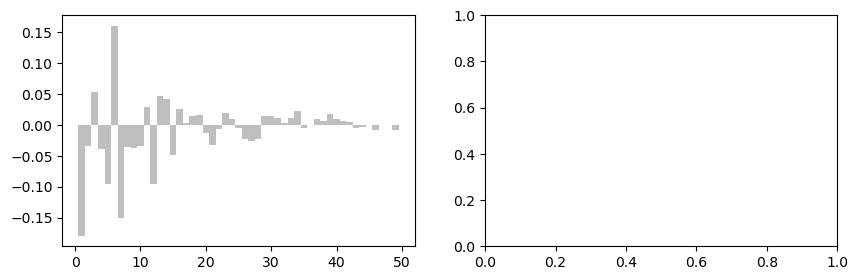

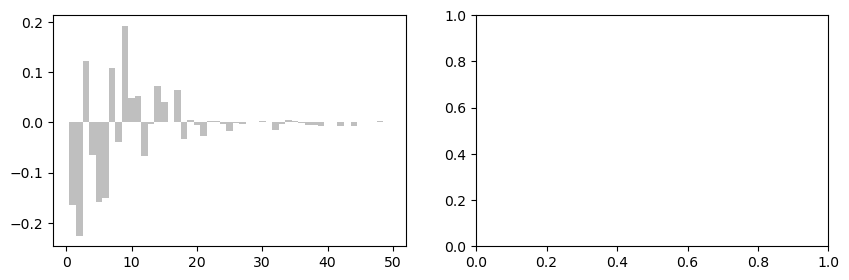

In [26]:
for r,climate in enumerate(climates):
    weight = xr.concat([ensembles[f"{climate}-x{i}"]['data']['uniq_seas'] for i in range(1,6)], dim='sim').sortby('sim')
    obs = xr.concat([ensembles[f"{climate}-x{i}"]['data']['tas'] for i in range(1,6)], dim='sim').sortby('sim')
    prob = xr.concat([ensembles[f"{climate}-x{i}"]['data']['prob'] for i in range(1,6)], dim='sim').sortby('sim')

    fig,axes = plt.subplots(ncols=2, figsize=(10,3))
    bins_len = np.arange(0.5,50.5,1)
    bins_start = np.arange(0.5,90.5,5)
    
    thresh = np.percentile(obs, 50)
    hw_len,hw_start = hw_stats(obs, thresh)
    count,_ = np.histogram(hw_len, bins=bins_len)
    count = count / 5 / 126

    thresh = np.percentile(ensembles[f"{climate}-initial"]['data']['tas'], 50)
    hw_len_i,hw_start = hw_stats(ensembles[f"{climate}-initial"]['data']['tas'], thresh)
    count_i,_ = np.histogram(hw_len_i, bins=bins_len)
    count_i = count_i / 126

    for xl,xh,c,c_i in zip(bins_len[:-1],bins_len[1:],count, count_i):
        axes[0].fill_between([xl,xh],[c - c_i]*2, color='gray', alpha=0.5, edgecolor='none')


### temporal autocorrelation

In [81]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
seas_cycle = ensembles[f'piControl-initial']['data']['tas'].mean('sim')
seas_cycle_smooth = lowess(seas_cycle.values, np.arange(1,91,1), frac=1./3)[:,1]

In [82]:
from statsmodels.tsa.ar_model import AutoReg

In [83]:
for ens_name, ens in ensembles.items():
    tas = ens['data']['tas']
    ens['data']['ar1c'] = xr.DataArray(
        [AutoReg(tas.loc[sim].values - seas_cycle_smooth, lags=1).fit().params[1] for sim in tas.sim.values],
        dims = ['sim'], coords = dict(sim=tas.sim)
    )
    

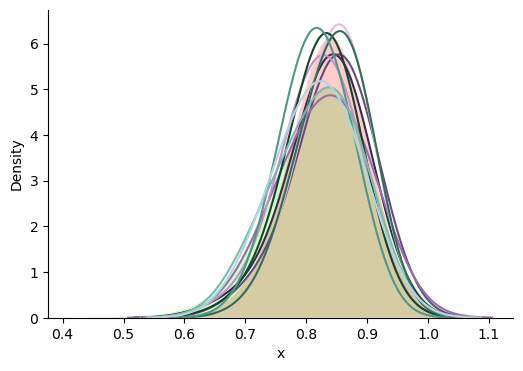

In [85]:
fig,ax = plt.subplots(figsize=(6,4))
ax.spines[['right', 'top']].set_visible(False)
for ens_name, ens in ensembles.items():
    if 'initial' in ens_name:
        sns.kdeplot(ens['data']['ar1c'], ax=ax, edgecolor='none', color=ens['color'], fill=True, alpha=0.2, bw_method=1)
    
    else:
        df = pd.DataFrame()
        df['x'] = ens['data']['ar1c']
        df['w'] = ens['data']['uniq_seas'].values.flatten()
        df['w'] /= df['w'].sum()
        sns.kdeplot(df, x='x', weights='w', ax=ax, color=ens['color'], bw_method=1)

Text(0.5, 0, 'AR1 coefficient')

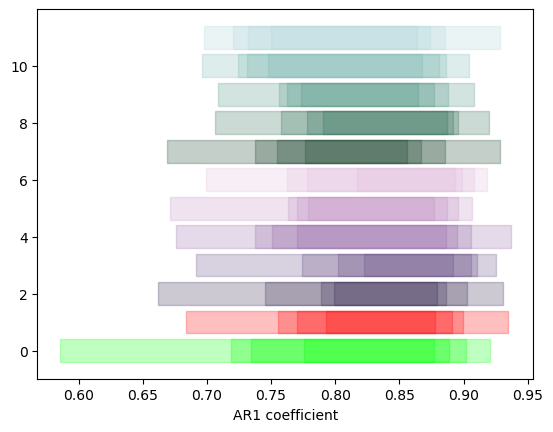

In [87]:
fig, ax = plt.subplots()
for y, ens in enumerate(ensembles.values()):
    for p in [0,5,10,17]:
        ax.fill_between(np.percentile(ens['data']['ar1c'], [p,100-p]), [y-0.4]*2, [y+0.4]*2, color=ens['color'], alpha=0.25)
ax.set_xlabel("AR1 coefficient")

In [86]:
# https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy
def weighted_percentile(data, weights, perc):
    """
    perc : percentile in [0-1]!
    """
    ix = np.argsort(data)
    data = data[ix] # sort data
    weights = weights[ix] # sort weights
    cdf = (np.cumsum(weights) - 0.5 * weights) / np.sum(weights) # 'like' a CDF function
    return np.interp(perc, cdf, data)

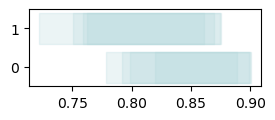

In [131]:
p = 0.01
p_low = p*0.8
p_high = p*1.2

fig, ax = plt.subplots(figsize=(3,1))
for r,climate in enumerate(climates):
    weight = xr.concat([ensembles[f"{climate}-x{i}"]['data']['uniq_seas'] for i in range(1,6)], dim='sim').sortby('sim')
    ar1c = xr.concat([ensembles[f"{climate}-x{i}"]['stat']['ar1c'] for i in range(1,6)], dim='sim').sortby('sim')
    prob = xr.concat([ensembles[f"{climate}-x{i}"]['data']['prob'] for i in range(1,6)], dim='sim').sortby('sim')
    selection = ((prob > p_low) & (prob < p_high))

    for p in [0,0.05,0.1,0.17]:
        ax.fill_between(
            weighted_percentile(ar1c[selection].values.flatten(), weight[selection].values.flatten(), [p,1-p]), 
            [r-0.4]*2, [r+0.4]*2, color=ens['color'], alpha=0.25)


In [128]:
def bootstrap(p_low, p_high):
    def func(ens):
        selection = ((ens['data']['prob'] > p_low) & (ens['data']['prob'] < p_high))
        return float(ens['data']['ar1c'][selection].weighted(ens['data']['uniq_seas'][selection]).mean()),  float(ens['data']['uniq_seas'][selection].sum())
    
    v_current = [func(ensembles[f"ssp370-2025-x{i}"]) for i in range(1,6)]
    l_current = [c for c in itertools.combinations_with_replacement(v_current, 5)]
    v_pic = [func(ensembles[f"piControl-x{i}"]) for i in range(1,6)]
    l_pic = [c for c in itertools.combinations_with_replacement(v_pic, 5)]

    combis = [c for c in itertools.product(l_current, l_pic)]
    xx = np.empty([len(combis)])
    for i,c in enumerate(combis):
        s_current, s_pic = c
        weight_current = np.array(s_current)[:,1]
        weight_pic = np.array(s_pic)[:,1]
        xx[i] = np.sum(np.array(s_current)[:,0] * weight_current) / weight_current.sum() - np.sum(np.array(s_pic)[:,0] * weight_pic) / weight_pic.sum()
    return xx

In [129]:
p = 0.01
p_low = p*0.7
p_high = p*1.3
bootstrap(p_low, p_high)

array([0.00466117, 0.00699747, 0.009478  , ..., 0.04199037, 0.03842878,
       0.03498745])

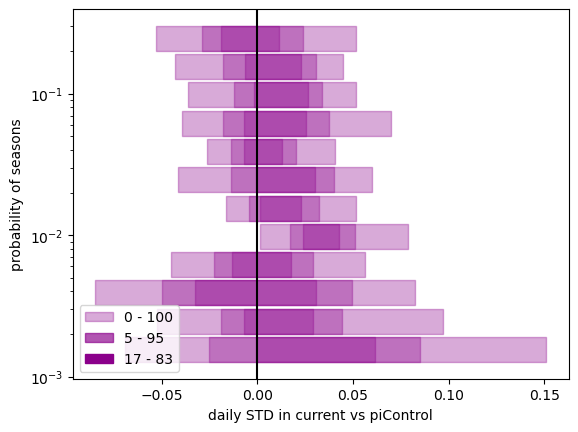

In [130]:
bs_l = []
prob_l = [10**i for i in np.arange(-0.6,-3,-0.2)]
for p in prob_l:
    p_low = p*0.7
    p_high = p*1.3
    xx = bootstrap(p_low, p_high)
    bs_l.append(xx)
    
fig,ax = plt.subplots()
for p,bs in zip(prob_l, bs_l):
    p_low = p*0.8
    p_high = p*1.2
    ax.fill_between(np.nanpercentile(bs, [0,100]), [p_low]*2, [p_high]*2, color='darkmagenta', alpha=1/3)
    ax.fill_between(np.nanpercentile(bs, [5,95]), [p_low]*2, [p_high]*2, color='darkmagenta', alpha=1/3)
    ax.fill_between(np.nanpercentile(bs, [17,83]), [p_low]*2, [p_high]*2, color='darkmagenta', alpha=1/3)

alpha=0
for p in [0,5,17]:
    alpha += 1/3
    ax.fill_between([],[],[], color='darkmagenta', alpha=alpha, label=f"{p} - {100-p}")
ax.set_yscale('log')
ax.axvline(0, color='k')
ax.set_xlabel('daily STD in current vs piControl')
ax.set_ylabel('probability of seasons')
ax.legend(loc='lower left')